## Optimizing logistic regression model:

-run a basic logistic regression with no tuning as a baseline model

-we see that there is a large difference in AUC values between the train and test data - likely overfitting

-ranked the feature importances and dropped the ones that were below a certain threshold
-features dropped: 'FVC', 'Cough', 'Age', 'FEV1_deficit', 'FEV1/FVC_deficit', 'FEV1^2',
       'FVC^2*FEV1', 'FVC*FEV1^2']; the features that are dropped depend on the train/test split, but usually the same engineered features are usually below the threshold

-performed cross validation and grid search on the dataset with dropped columns

-redid the logistic regression with hyperparameter tuning and dropped features

-the difference in AUC values between the train and test data has significantly dropped

-the AUC (on the test data) has increased after the hyperparameter tuning and dropped columns

In [1]:
def surgery_preprocess(split=True): # If split=True, return the split; else, return all data
    import pandas as pd
    import numpy as np
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    
    ### Load/subset/merge NHANES data ###
    
    # Read in the datasets
    spirometry = pd.read_sas('SPX_G.XPT')
    demographics = pd.read_sas('DEMO_G.XPT')
    body = pd.read_sas('BMX_G.XPT')
    enx = pd.read_sas('ENX_G.XPT')
    bpx = pd.read_sas('BPX_G.XPT')

    
    # Subset the datasets
    subset = spirometry[['SPXNFVC', 'SPXNFEV1', 'SEQN', 
                             'ENQ010', 'ENQ020', 'SPQ040', 'ENQ100', 
                             'SPQ050', 'SPQ060','SPQ070B', 'SPQ100']]
    demographics = demographics[['RIDAGEYR', 'RIAGENDR', 'SEQN']]
    body = body[['BMXHT', 'BMXWT', 'SEQN']]
    enx = enx[['ENQ040','ENQ090','ENXTR4Q','SEQN']]
    bpx = bpx[['BPQ150D','SEQN']]
    
    # Merge the datasets by SEQN
    subset = pd.merge(subset, demographics, 'left', 'SEQN')
    subset = pd.merge(subset, body, 'left', 'SEQN')
    subset = pd.merge(subset, enx, 'left', 'SEQN')
    subset = pd.merge(subset, bpx, 'left', 'SEQN')
    subset.rename(columns = {'SPXNFVC': 'FVC', 'SPXNFEV1': 'FEV1',
                            'RIDAGEYR': 'Age', 'RIAGENDR': 'Sex', 
                            'BMXHT': 'Height', 'BMXWT': 'Weight'}, inplace=True)
    
    # entries prior to filtering: 7495
    subset = subset[(subset['ENQ010'] !=1) & (subset['ENQ020']!=1) &
                    (subset['SPQ040']!=1) & (subset['SPQ050']!=1) & (subset['SPQ060']!=1) &
                    (subset['SPQ070B']!=2) & ( subset['SPQ100']!=1) & (subset['ENQ100']!=1) &
                    (subset['ENQ040']!=1) & (subset['ENQ090']!=1)]
    
    subset.dropna(axis=0, subset=['FVC','Age','FVC'])
    # 4950 entries
    
    # Get mean FVC and FEV1 per age
    estimates = subset.groupby('Age')[['FVC', 'FEV1']].mean()
    estimates.rename(columns={'FVC':'mean_FVC', 'FEV1':'mean_FEV1'}, inplace=True) 
    
    ### Load and clean surgery data, and merge variables from NHANES data ###
    
    # Read in surgery data
    surgery = pd.read_csv('ThoracicSurgery.csv', index_col = 0)
    
    # Rename variables
    surgery.rename(columns = {'DNG': 'Diagnosis', 'PRE4': 'FVC',
                            'PRE5': 'FEV1', 'PRE6': 'Performance',
                            'PRE7': 'Pain', 'PRE8': 'Haemoptysis',
                            'PRE9': 'Dyspnoea', 'PRE10': 'Cough',
                            'PRE11': 'Weakness', 'PRE14': 'Tumor_size',
                            'PRE17': 'Type2_diabetes', 'PRE19': 'MI_6months',
                            'PRE25': 'PAD', 'PRE30': 'Smoking',
                            'PRE32': 'Asthma', 'AGE': 'Age'}, inplace=True)
    print(surgery.columns)
    
    # Back to NHANES data for a bit...
    # Impute mean FVC and FEV1 for ages 80+ using a simple linear regression
    # We only have 8 people of ages 80+ in our data. (Ages: 80,81,87)

    # To get a good linear fit, zoom into the age range where both mean FVC and FEV1 start to steadily decline
    lr_estimates = estimates[estimates.index > 25]
    
    # Fit linear regression to FVC and FEV1
    lr_FVC = LinearRegression(fit_intercept=True,normalize=True).fit(lr_estimates.index.values.reshape(-1, 1),lr_estimates['mean_FVC'])
    lr_FEV1 = LinearRegression(fit_intercept=True,normalize=True).fit(lr_estimates.index.values.reshape(-1, 1),lr_estimates['mean_FEV1'])
    
    # Impute the mean FVC and FEV1 for ages 80 - maximum age in the surgery dataset and append
    pred_ages = np.arange(80,surgery.Age.max()+1).reshape(-1,1)
    lr_estimates = pd.DataFrame([lr_FVC.predict(pred_ages).flatten(),lr_FEV1.predict(pred_ages).flatten()]).T
    lr_estimates.columns = estimates.columns
    lr_estimates.index = pred_ages.flatten()
    estimates = estimates.append(lr_estimates)
    
        # Fix errorneous FEV1 values (greater than corresponding FVC)
    errs = surgery.loc[(surgery.FEV1 > surgery.FVC),:].index
    for i in errs:
        patient = surgery.iloc[i,:]
        near_age = surgery.loc[(surgery.Age >= patient.Age-2) & (surgery.Age <= patient.Age+2),:]
        near_age = near_age.loc[~near_age.index.isin(errs)]
        surgery.loc[i,'FEV1'] = near_age.FEV1.mean()
        
    # Compute new features from surgery/NHANES data
    surgery['FEV1/FVC'] = surgery['FEV1'] / surgery['FVC']
    surgery['expected_FVC'] = estimates.loc[surgery.Age, 'mean_FVC'].values / 1000
    surgery['expected_FEV1'] = estimates.loc[surgery.Age, 'mean_FEV1'].values / 1000
    surgery['expected_FEV1/FVC'] = surgery['expected_FEV1'] / surgery['expected_FVC']
    surgery['FEV1_deficit'] = surgery['expected_FEV1']-surgery['FEV1']
    surgery['Relative_FEV1_deficit'] = surgery['FEV1_deficit'] / surgery['expected_FEV1']
    surgery['FVC_deficit'] = surgery['expected_FVC']-surgery['FVC']
    surgery['Relative_FVC_deficit'] = surgery['FVC_deficit'] / surgery['expected_FVC']
    surgery['FEV1/FVC_deficit'] = surgery['expected_FEV1/FVC']-surgery['FEV1/FVC']
    surgery['Relative_FEV1/FVC_deficit'] = surgery['FEV1/FVC_deficit'] / surgery['expected_FEV1/FVC']
    surgery['FEV1^2'] = surgery['FEV1']**2
    surgery['FVC^2'] = surgery['FVC']**2
    surgery['Age*FVC'] = surgery['Age']*surgery['FVC']
    surgery['Age*FEV1'] = surgery['Age']*surgery['FEV1']
    surgery['FVC*FEV1'] = surgery['FVC']*surgery['FEV1']
    surgery['FVC^2*FEV1'] = surgery['FEV1']*(surgery['FVC']**2)
    surgery['FVC*FEV1^2'] = surgery['FVC']*(surgery['FEV1']**2)
    
    # Won't be needing these for modeling... already got what we wanted to compute from these
    surgery.drop(columns=['expected_FVC', 'expected_FEV1', 'expected_FEV1/FVC'], inplace=True)

    # Select this right after engineering new features, but
    # before changing F/T to 0/1, so we don't scale ordinal/binary features
    numeric_cols = surgery.select_dtypes('number').columns
    
    # Clean up string/bool data
    surgery.loc[:,surgery.dtypes=='object']= surgery.loc[:,surgery.dtypes=='object'].apply(lambda s: (s.str.replace("\'", "").str.replace('b', '')))
    surgery.replace(to_replace = ['F', 'T'], value=[0,1], inplace=True)

    ord_cols = ['Performance', 'Tumor_size']
    for col in ord_cols:
        surgery[col] = surgery[col].str.strip().str[-1].astype(int)
        
    # Remove diagnoses with too little data (n=1,4,2)
    surgery = surgery[~(surgery.DGN.isin(['DGN1', 'DGN6', 'DGN8']))]
    # Turn our categorical DGN feature to boolean _DGNx features
    surgery = pd.get_dummies(surgery, prefix=[''], columns=['DGN'])
    
    ### Return the preprocessed data ###
    if split == False:
        return surgery
    else:
        ### Split the data ###
        X_train, X_test, y_train, y_test = train_test_split(surgery.drop('Risk1Yr', axis=1),
                                                            surgery['Risk1Yr'], test_size=0.2,
                                                            shuffle=True)
        ### Normalize numeric features ###
        scaler = StandardScaler()
        # Fit the test data in the same scale as the training data
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

        ### Return the split train/test data ###
        return X_train, X_test, y_train, y_test

In [2]:
import pandas as pd
import numpy as np

X_train, X_test, y_train, y_test = surgery_preprocess(split=True)
X_train_columns = X_train.columns

Index(['DGN', 'FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 'Dyspnoea',
       'Cough', 'Weakness', 'Tumor_size', 'Type2_diabetes', 'MI_6months',
       'PAD', 'Smoking', 'Asthma', 'Age', 'Risk1Yr'],
      dtype='object')


### Testing basic logistic regression model with no tuning:

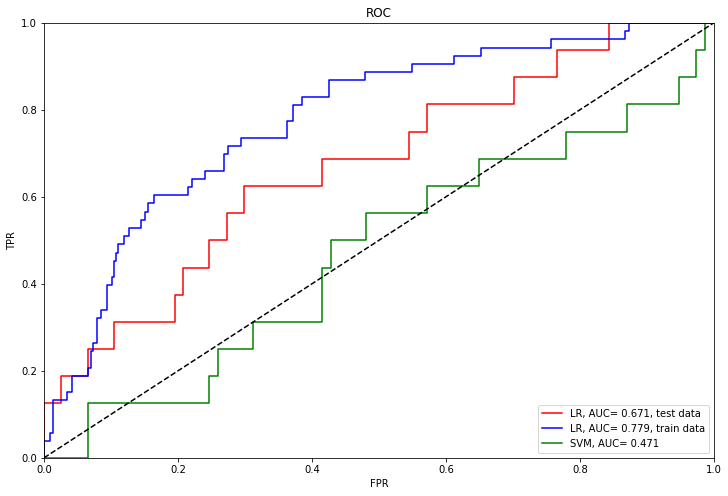

In [3]:
# Logistic regression model
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
%matplotlib inline

plt.figure(figsize = (12, 8))

# Fit the logistic regression model on the test data
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
log_reg_preds = log_reg.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, log_reg_preds)
lr_roc_auc = roc_auc_score(y_test, log_reg_preds)
plt.plot(lr_fpr, lr_tpr, color='red', label='LR, AUC= %0.3f, test data' %lr_roc_auc)

# Fit the logistic regression model on the train data
log_reg_preds_train = log_reg.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, log_reg_preds_train)
roc_auc = roc_auc_score(y_train, log_reg_preds_train)
plt.plot(fpr, tpr, color='blue', label='LR, AUC= %0.3f, train data' %roc_auc)

# Perform the SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict_proba(X_test)[:, 1]
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_preds)
svm_roc_auc = roc_auc_score(y_test, svm_preds)
plt.plot(svm_fpr, svm_tpr, color='green', label='SVM, AUC= %0.3f' %svm_roc_auc)

# Plot the ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')

### Determine feature importance and see which ones to drop

C:\Users\Poey\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


0.11380094292118559
Index(['Performance', 'PAD', 'FEV1_deficit', 'Relative_FVC_deficit',
       'FEV1/FVC_deficit', 'Age*FVC', 'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2'],
      dtype='object')


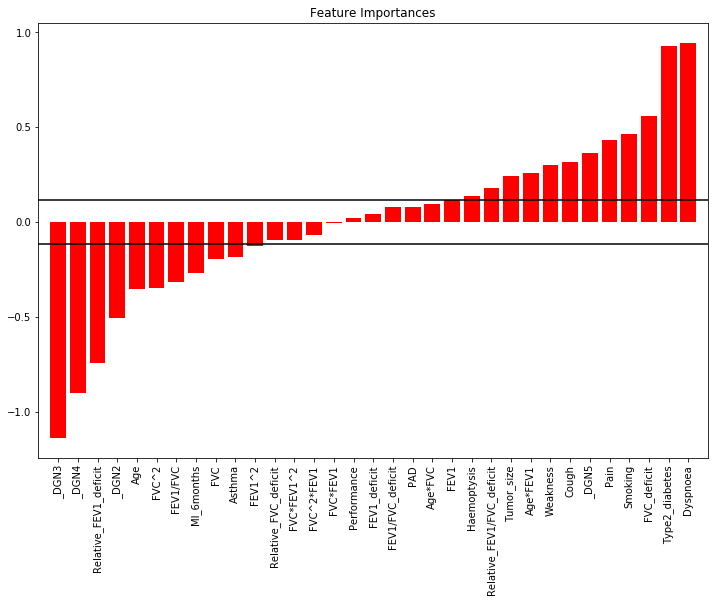

In [4]:
feature_mi = log_reg.coef_
feature_mi = np.array(feature_mi[0,:])
indices = np.argsort(-feature_mi)[::-1]


sorted_labels = []
for i in indices:
     sorted_labels.append(X_train_columns[i])

df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_mi})
df2 = df.iloc[df.Importance.abs().argsort()]
df2['AbsVal'] = df2['Importance'].abs()
threshold = 0.1 * df2['AbsVal'].max()
print(threshold)
# print(df2)
# print(df2.abs().max(axis=0))

# threshold = 0.1 * np.abs()
drop_features = X_train_columns[np.abs(feature_mi)<threshold]
print(drop_features)
plt.figure(figsize = (12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), feature_mi[indices], color='r', align='center')
plt.xticks(range(X_train.shape[1]), sorted_labels, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.hlines(threshold, -10, 40)
plt.hlines(-threshold, -10, 40)
plt.show()

### Drop the features that are determined to be below some threshold:

Dropped features: Index(['Performance', 'PAD', 'FEV1_deficit', 'Relative_FVC_deficit',
       'FEV1/FVC_deficit', 'Age*FVC', 'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2'],
      dtype='object')


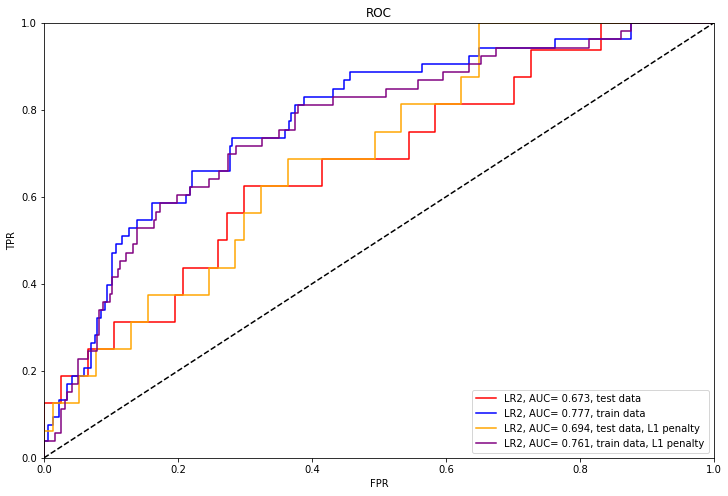

In [5]:
plt.figure(figsize = (12, 8))
print('Dropped features:', drop_features)

# Drop the least important features
X_train2 = X_train.drop(drop_features, axis=1)
X_test2 = X_test.drop(drop_features, axis=1)

# Fit the logistic regression model for test data
log_reg2 = LogisticRegression(solver='liblinear')
log_reg2.fit(X_train2, y_train)
log_reg_preds2 = log_reg2.predict_proba(X_test2)[:,1]
lr_fpr2, lr_tpr2, lr_thresholds2 = roc_curve(y_test, log_reg_preds2)
lr_roc_auc2 = roc_auc_score(y_test, log_reg_preds2)
plt.plot(lr_fpr2, lr_tpr2, color='red', label='LR2, AUC= %0.3f, test data' %lr_roc_auc2)

# Fit the logistic regression model on the train data
log_reg_preds_train2 = log_reg2.predict_proba(X_train2)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train, log_reg_preds_train2)
roc_auc2 = roc_auc_score(y_train, log_reg_preds_train2)
plt.plot(fpr2, tpr2, color='blue', label='LR2, AUC= %0.3f, train data' %roc_auc2)


# Calculate the logistic regression with the L1 penalty
log_reg2_penalty = LogisticRegression(solver='liblinear', penalty='l1')
log_reg2_penalty.fit(X_train2, y_train)
log_reg_preds2_penalty = log_reg2_penalty.predict_proba(X_test2)[:,1]
lr_fpr2_penalty, lr_tpr2_penalty, lr_thresholds2_penalty = roc_curve(y_test, log_reg_preds2_penalty)
lr_roc_auc2_penalty = roc_auc_score(y_test, log_reg_preds2_penalty)
plt.plot(lr_fpr2_penalty, lr_tpr2_penalty, color='orange', 
         label='LR2, AUC= %0.3f, test data, L1 penalty' %lr_roc_auc2_penalty)

# Fit the logistic regression model on the train data
log_reg_preds_train2_penalty = log_reg2_penalty.predict_proba(X_train2)[:,1]
fpr2_penalty, tpr2_penalty, thresholds2_penalty = roc_curve(y_train, log_reg_preds_train2_penalty)
roc_auc2_penalty = roc_auc_score(y_train, log_reg_preds_train2_penalty)
plt.plot(fpr2_penalty, tpr2_penalty, color='purple', 
         label='LR2, AUC= %0.3f, train data, L1 penalty' %roc_auc2_penalty)

# Plot the ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')

### Cross validation with all columns in data:

In [6]:

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Set model and parameters to test
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [0.01, 0.1, 1, 10, 100]

# Perform the grid search on the parameters
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = KFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.645672 using {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


### Cross validation with dropped columns:

In [7]:
# Set model and parameters to test
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [0.01, 0.1, 1, 10, 100]

# Perform the grid search on the parameters
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = KFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train2, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.656738 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


### Logistic regression model with hyperparameter tuning and dropped features:

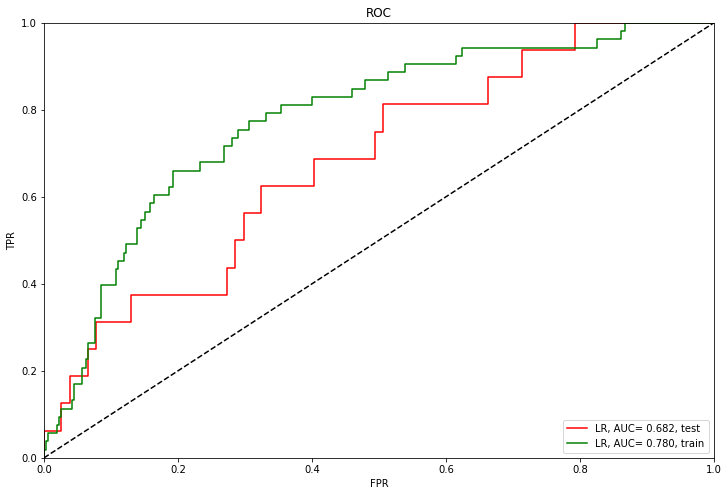

In [8]:
plt.figure(figsize = (12, 8))

# Logistic regression on test data with dropped columns
log_reg_xval = LogisticRegression(solver=grid_result.best_params_['solver'], 
                                  penalty=grid_result.best_params_['penalty'], C=grid_result.best_params_['C'])
log_reg_xval.fit(X_train2, y_train)
log_reg_preds_xval = log_reg_xval.predict_proba(X_test2)[:,1]
lr_fpr_xval, lr_tpr_xval, lr_thresholds_xval = roc_curve(y_test, log_reg_preds_xval)
lr_roc_auc_xval = roc_auc_score(y_test, log_reg_preds_xval)
plt.plot(lr_fpr_xval, lr_tpr_xval, color='red', label='LR, AUC= %0.3f, test' %lr_roc_auc_xval)

# Logistic regression with train data with dropped columns
log_reg_preds_xval_train = log_reg_xval.predict_proba(X_train2)[:,1]
lr_fpr_xval_train, lr_tpr_xval_train, lr_thresholds_xval_train = roc_curve(y_train, log_reg_preds_xval_train)
lr_roc_auc_xval_train = roc_auc_score(y_train, log_reg_preds_xval_train)
plt.plot(lr_fpr_xval_train, lr_tpr_xval_train, color='green', label='LR, AUC= %0.3f, train' %lr_roc_auc_xval_train)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()